# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2

import glob

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
import collections

Using TensorFlow backend.


# Prepare dataset

## Prepare CrowdAI annotations
Since I'm using an approach based on U-Net (https://arxiv.org/abs/1505.04597) the data preprocessing looks quite different to my first approaches with HOG. As input data (X_train) we use the images provided without any annotations on them. I keep all three color channels, since it had very positive effects on the model quality. To save GPU memory, the images are resized to size=(384, 240). The target data (y_train) consists of masks of the same size. Areas without cars have a value=0 and areas with car have a value=1. We get this information out of the provided bounding boxes.

In [2]:
src = 'data/crowdai/'
image_data = pd.read_csv(src+'labels.csv')
image_data.head()

X_train = []
y_train = []

img_paths = np.unique(image_data.Frame)

n_skip = 5

skip = 0
for img_path in img_paths:
    if skip == n_skip:
        full_path = src + img_path
        img_subset = image_data[image_data.Frame == img_path]

        X_img = plt.imread(full_path)

        y_img = np.zeros_like(X_img)[:,:,0]

        for i in range(len(img_subset)):
            car_loc = img_subset.iloc[i]

            x1, x2, y1, y2 = car_loc.xmin, car_loc.ymin, car_loc.xmax, car_loc.ymax
            y_img[y1:y2, x1:x2] = 1

        X_img = cv2.resize(X_img, (384, 240))
        y_img = cv2.resize(y_img, (384, 240))

        X_train.append(X_img)
        y_train.append(y_img)
        skip = 0
    else:
        skip += 1



## Prepare KTTI data
I also wanted to make use of the KTTI data. As is, it can't be directly used for training a U-Net. We directly have the crops of cars and non-cars, which could be used for example if using Fully Convolutional Networks. In the U-Net setting we need masks. I therefore create mosaics of random non-car images and place one resized random car crop somewhere in the image. Accordingly the masks (y_train) are produced by creating a np.zeros array and only setting value=1 where we put the car. The results don't look realistic but seem to help the model to generalize quite well.

In [3]:
car_files = glob.glob("data/vehicles2/*/*.png")
no_car_files = glob.glob("data/non-vehicles2/*/*.png")

img_files = np.hstack([car_files, no_car_files])

In [4]:
img_rows = 4
img_cols = 5

patch_size = 64

for i in range(1000):
    rnd_imgs = np.random.randint(len(no_car_files), size=img_rows*img_cols)

    counter = 0


    full_img = []

    for row in range(img_rows):
        img_row = []

        for col in range(img_cols):
            file_path = no_car_files[rnd_imgs[counter]]
            img = plt.imread(file_path)
            img_row.append(img)
            counter += 1

        img_row = np.hstack(img_row)
        full_img.append(img_row)

    full_img = np.vstack(full_img)


    car_idx = np.random.randint(len(car_files))
    car_path = car_files[car_idx]
    car_img = plt.imread(car_path)

    car_size = np.random.randint(low=int(patch_size/3), high=patch_size)
    car_img = cv2.resize(car_img, (car_size,car_size))

    car_y = np.random.randint(full_img.shape[0]-car_size)
    car_x = np.random.randint(full_img.shape[1]-car_size)

    full_img[car_y:car_y+car_size, car_x:car_x+car_size] = car_img

    mask = np.zeros_like(full_img)[:,:,0]
    mask[car_y:car_y+car_size, car_x:car_x+car_size] = 1
    
    full_img = cv2.resize(full_img, (X_train[0].shape[1], X_train[0].shape[0]))
    mask = cv2.resize(mask, (X_train[0].shape[1], X_train[0].shape[0]))
    
    X_train.append(full_img*255.)
    y_train.append(mask)

In [5]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [6]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

In [9]:
X_train = np.load("X_train.npy")#.mean(axis=3).astype("float16")
y_train = np.load("y_train.npy")

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],3) / 255.
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],y_train.shape[2],1)

Show example image.


(-0.5, 383.5, 239.5, -0.5)

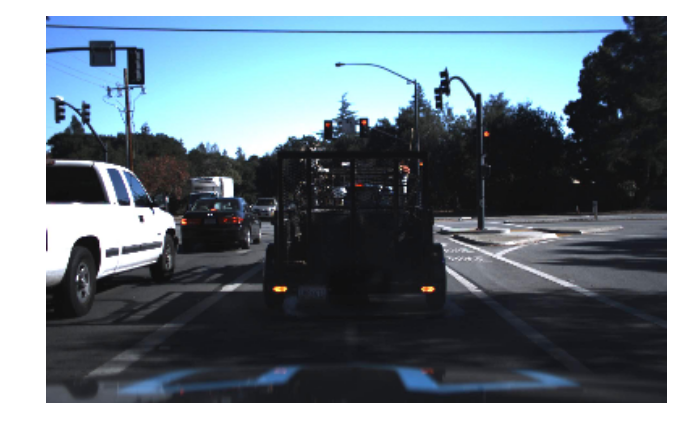

In [10]:
print("Show example image.")
plt.imshow(X_train[155])
plt.axis('off')

# Segmentation training with U-Net
As already described I use an approach totally relying on U-Net and used code examples from https://github.com/jocicmarko/ultrasound-nerve-segmentation to build the model in Keras. For this a custom loss function is implemented, which should get quite close to the intersection over union.

In [11]:

### The following model is strongly inspired by the one provided by https://github.com/jocicmarko/ultrasound-nerve-segmentation

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]


# this is a "simple" implementation of the intersection over union, 
# which is basically just a multiply between predicted and target mask divided by a normalization factor

def iou_loss(y_true, y_pred):
    iou_simple = 2 * K.sum(K.flatten(y_true) *K.flatten(y_pred))
    return -(iou_simple / (K.sum(K.flatten(y_true))+K.sum(K.flatten(y_pred))))

def UNet():
    input = Input((img_rows, img_cols, 3))
    conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_1)
    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_2)
    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_3)
    conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
    conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_5)

    unpool_6 = concatenate([UpSampling2D(size=(2, 2))(conv_5), conv_4], axis=3)
    conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(unpool_6)
    conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_6)

    unpool_7 = concatenate([UpSampling2D(size=(2, 2))(conv_6), conv_3], axis=3)
    conv_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(unpool_7)
    conv_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_7)

    unpool_8 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_2], axis=3)
    conv_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(unpool_8)
    conv_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_8)

    unpool_9 = concatenate([UpSampling2D(size=(2, 2))(conv_8), conv_1], axis=3)
    conv_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(unpool_9)
    conv_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv_9)

    model = Model(inputs=[input], outputs=[output])

    model.compile(optimizer=Adam(lr=1e-4), loss=iou_loss)

    return model

In [12]:
model = UNet()

In [13]:
I didn't run this cell for the final notebook compilation, since I already obtained the best weights during an other iteration

checkpoint = ModelCheckpoint(filepath="new_weights.h5", verbose=1, save_best_only=True, mode="min")

model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_split=0.15, callbacks=[checkpoint])

# Prediction on project video

In [15]:
# From http://stackoverflow.com/questions/10016352/convert-numpy-array-to-tuple
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a
    
# Code from the lecture 
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Code from the lecture 
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
    # Return the image
    return img

In [16]:
heatmap_queue = collections.deque(maxlen=2) # used for interpolation between frames

def process_frame(img):
    img_orig = np.copy(img)
    img_orig = cv2.resize(img_orig, (img_cols, img_rows))

    img_colored = np.copy(img_orig)

    img_colored = cv2.resize(img_colored, (img_cols, img_rows))
    img_colored = img_colored/255.
    pred = model.predict(img_colored.reshape(1,img_rows, img_cols, 3))[0,:,:,0]
    pred[0:int(pred.shape[0]/2), :] = 0
    heatmap = apply_threshold(pred, 0.99)
    heatmap_queue.append(heatmap)
    heatmap = np.asarray(heatmap_queue).mean(axis=0)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img_orig), labels)
    return draw_img

Show example prediction


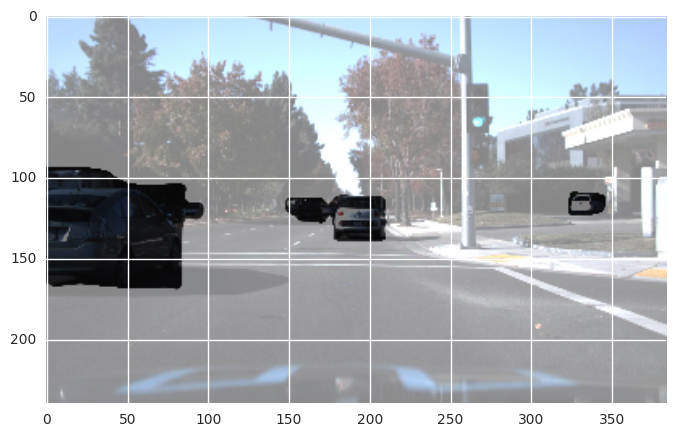

In [18]:
print("Show example prediction")
idx = 811
plt.imshow(X_train[idx].astype("float32"))
plt.imshow(model.predict(X_train[idx:idx+1])[0,:,:,0], alpha=0.5)

In [19]:
# Import everything needed to edit/save/watch video clips

model.load_weights("new_weights.h5")

white_output = 'video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video video.mp4
[MoviePy] Writing video video.mp4


100%|█████████▉| 1260/1261 [00:18<00:00, 67.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video.mp4 

CPU times: user 18.1 s, sys: 3.28 s, total: 21.4 s
Wall time: 19 s
